In [27]:
%matplotlib notebook
from matplotlib import pyplot as plt
from matplotlib import animation
from matplotlib.patches import Circle
from matplotlib.collections import PatchCollection
import numpy as np
from scipy.spatial.distance import pdist
import pandas as pd
from read_roi import read_roi_file
from math import floor, ceil, sqrt
from cluster.pair_correlation import (
    pc_corr,
    fit_correlation,
    fit_exponential_gaussian,
    ripleyLfunction,
    ripley_ci,
    fit_exponential,
    fit_psf
)
from cluster.ripley import RipleysKEstimator

In [28]:
# parameters
size_x = 500 # region size in arbitrary units
size_y = 500
mask = np.ones((size_y, size_x))
density = 1e-3
Nbg = 100
N = density * size_x * size_y # num of particles
num_clusters = 25 # number of domains
particles_per_cluster = floor(float(N)/float(num_clusters))
print(particles_per_cluster)
cluster_radius = 25 # radius of domain
psf_sigma = 2 # PSF radius

10


In [13]:
# define some random points to simulate background
x = np.random.uniform(low=0, high=size_x, size=(Nbg, 1))
y = np.random.uniform(low=0, high=size_y, size=(Nbg, 1))
green_centers = np.hstack((x, y))
green_centers_density = np.histogramdd(green_centers, bins=(size_y, size_x))[0]

In [14]:
# add some over counting
ocr = 3
green_signals = []
for c in range(green_centers.shape[0]):
    num_ocr = np.random.randint(0, ocr, size=1)[0]
    g = np.random.normal(green_centers[c, :], psf_sigma, size=(num_ocr, 2))
    if g.shape[0] > 0:
        green_signals.append(g)
    
green_signals = np.vstack(green_signals)
all_green = np.vstack((green_centers, green_signals))
all_green_density = np.histogramdd(all_green, bins=(size_y, size_x))[0]

In [29]:
# define domain centers from uniformly distributed random numbers
x = np.random.uniform(low=0, high=size_x, size=(num_clusters, 1))
y = np.random.uniform(low=0, high=size_y, size=(num_clusters, 1))
radii = np.ones(num_clusters) * cluster_radius
domain_centers = np.hstack((x, y))
patches = []
for x1, y1, r in zip(x, y, radii):
    circle = Circle((x1, y1), r, color='lightgrey')
    patches.append(circle)

In [19]:
x = np.random.uniform(low=0, high=size_x, size=(num_clusters, 1))
y = np.random.uniform(low=0, high=size_y, size=(num_clusters, 1))
radii = np.ones(num_clusters) * cluster_radius
cross_domain_centers = np.hstack((x, y))
# patches = []
for x1, y1, r in zip(x, y, radii):
    circle = Circle((x1, y1), r, color='lightgrey')
    patches.append(circle)

In [5]:
cross_domain_centers = domain_centers
radii = np.ones(num_clusters) * cluster_radius
x = cross_domain_centers[:, 0]
y = cross_domain_centers[:, 1]
cross_patches = []
for x1, y1, r in zip(x, y, radii):
    circle = Circle((x1, y1), r, color='lightgrey')
    cross_patches.append(circle)

In [30]:
# define clusters - circular domains of uniformly distributed random numbers
red_centers = []
for c in range(num_clusters):
    cluster = np.array(
        (
                    np.random.uniform(-cluster_radius, cluster_radius, particles_per_cluster),
                    np.random.uniform(-cluster_radius, cluster_radius, particles_per_cluster)
        )
    )

    cluster = cluster[:, np.sqrt(np.square(cluster[0,:]) + np.square(cluster[1,:])) < cluster_radius]
    cluster[0,:] = cluster[0,:] + domain_centers[c, 0]
    cluster[1,:] = cluster[1,:] + domain_centers[c, 1]
    
    red_centers.append(cluster.T)

red_centers = np.vstack(red_centers)
red_centers_density = np.histogramdd(red_centers, bins=(size_y, size_x))[0]

In [21]:
# define clusters - circular domains of uniformly distributed random numbers
blue_centers = []
for c in range(num_clusters):
    cluster = np.array(
        (
                    np.random.uniform(-cluster_radius, cluster_radius, particles_per_cluster),
                    np.random.uniform(-cluster_radius, cluster_radius, particles_per_cluster)
        )
    )

    cluster = cluster[:, np.sqrt(np.square(cluster[0,:]) + np.square(cluster[1,:])) < cluster_radius]
    cluster[0,:] = cluster[0,:] + cross_domain_centers[c, 0]
    cluster[1,:] = cluster[1,:] + cross_domain_centers[c, 1]
    
    blue_centers.append(cluster.T)

blue_centers = np.vstack(blue_centers)
blue_centers_density = np.histogramdd(blue_centers, bins=(size_y, size_x))[0]

In [31]:
# define over-counting - overcounting ratio (OCR) = 1 picked from random numbers with normal distribution
ocr = 3
red_signals = []
for c in range(red_centers.shape[0]):
    num_ocr = np.random.randint(0, ocr, size=1)[0]
    g = np.random.normal(red_centers[c, :], psf_sigma, size=(num_ocr, 2))
    if g.shape[0] > 0:
        red_signals.append(g)
    
red_signals = np.vstack(red_signals)
all_red = np.vstack((red_centers, red_signals))
all_red_density = np.histogramdd(all_red, bins=(size_y, size_x))[0]

<IPython.core.display.Javascript object>


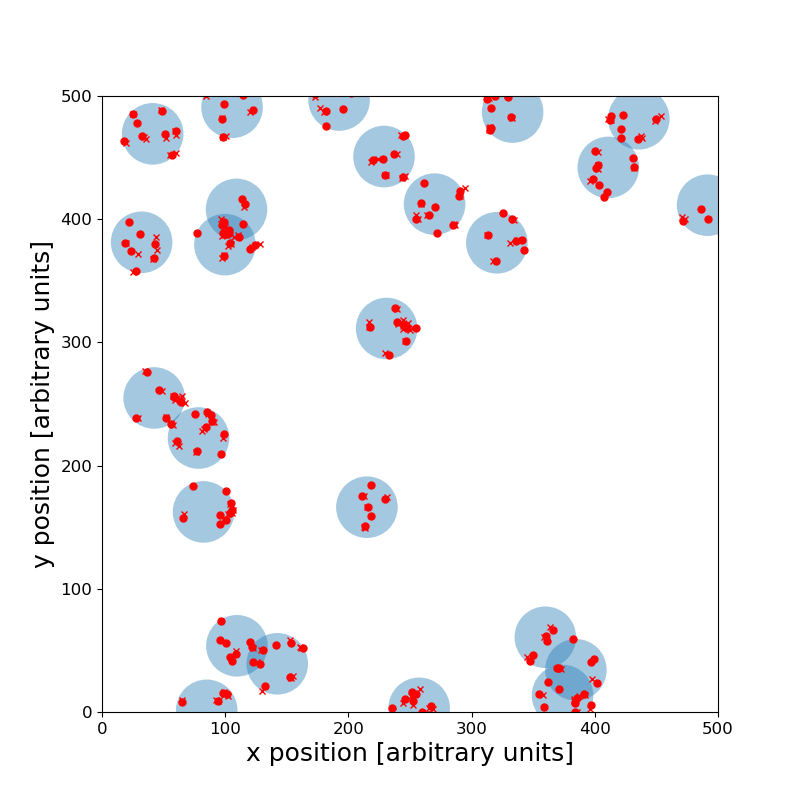

In [33]:
figure = plt.figure(figsize=(8,8), dpi=100)
ax = figure.add_subplot(111, aspect=1)
# ax.plot(green_centers[:, 0], green_centers[:, 1], 'go', markersize=2)
# ax.plot(green_signals[:, 0], green_signals[:, 1], 'gx', markersize=2)
# ax.plot(domain_centers[:, 0], domain_centers[:, 1], 'bo', markersize=2)
ax.plot(red_centers[:, 0], red_centers[:, 1], 'ro', markersize=5)
# ax.plot(blue_centers[:, 0], blue_centers[:, 1], 'go', markersize=5)
ax.plot(red_signals[:, 0], red_signals[:, 1], 'rx', markersize=5)
p1 = PatchCollection(patches, alpha=0.4)
# p2 = PatchCollection(cross_patches, alpha=0.4)
ax.add_collection(p1)
# ax.add_collection(p2)
ax.tick_params(labelsize='large')
plt.xlabel('x position [arbitrary units]', fontsize=18)
plt.ylabel('y position [arbitrary units]', fontsize=18)
plt.axis([0, size_x, 0, size_y])
plt.show()

(64980,)
(17766,)


<IPython.core.display.Javascript object>


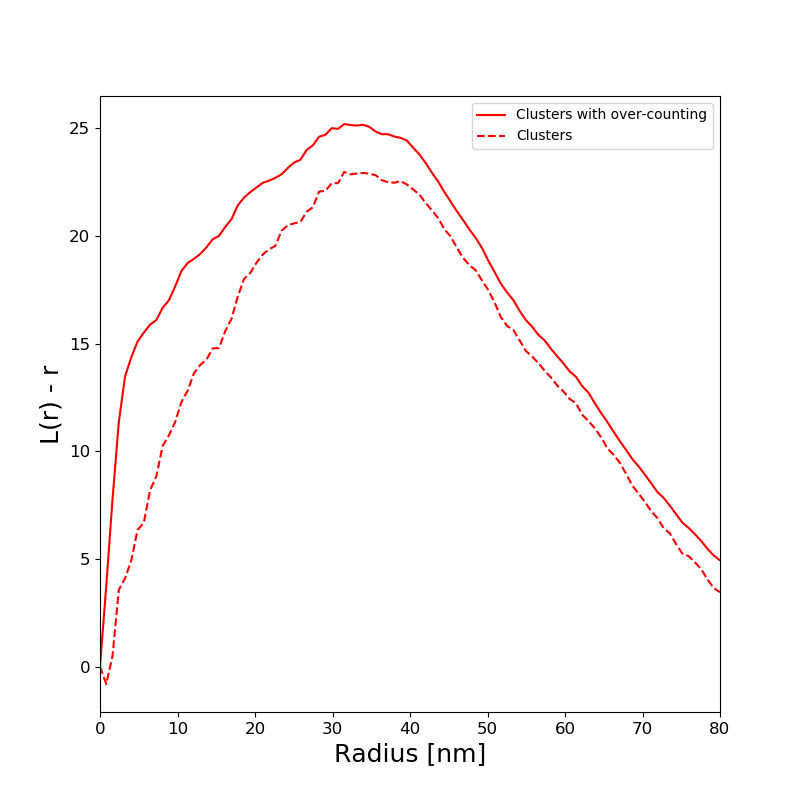

In [41]:
Kdata = RipleysKEstimator(500*500, x_max=500, x_min=0, y_max=500, y_min=0)
r = np.linspace(0, 80, 100)
Hall = Kdata.Hfunction(all_red, r, mode='none')
Hrc = Kdata.Hfunction(red_centers, r, mode='none')

figure = plt.figure(figsize=(8,8), dpi=100)
ax = figure.add_subplot(111)
ax.plot(np.linspace(0, 80, 100), Hall, 'r-', label='Clusters with over-counting')
ax.plot(np.linspace(0, 80, 100), Hrc, 'r--', label='Clusters')
ax.set_xlim([0, 80])
ax.tick_params(labelsize='large')
ax.legend()
plt.xlabel('Radius [nm]', fontsize=18)
plt.ylabel('L(r) - r', fontsize=18)
plt.show()

In [26]:
cross_centers, r = pc_corr(image1=red_centers_density, image2=blue_centers_density, region=mask, rmax=100)
print(cross_centers.shape)
guess = [10, 2]
cross_centers_curve, cross_centers_result = fit_correlation(cross_centers, r, fit_exponential, guess=guess)
print(cross_centers_result)

(1, 101)
[ 0.46145409 17.07301173]


In [16]:
g_centers, r = pc_corr(image1=green_centers_density, image2=green_centers_density, region=mask, rmax=200)
guess = [2, 0.0149]
g_centers_curve, g_centers_result = fit_correlation(g_centers, r, fit_psf, guess=guess)

g_all, r = pc_corr(image1=all_green_density, image2=all_green_density, region=mask, rmax=200)
guess = [2, 0.0149]
g_all_curve, g_all_result = fit_correlation(g_all, r, fit_psf, guess=guess)
print(g_all_result)

r_centers, r = pc_corr(image1=red_centers_density, image2=red_centers_density, region=mask, rmax=200)
guess = [2, 1e-3, 80, 20, 1]
r_centers_curve, r_centers_result = fit_correlation(r_centers, r, fit_exponential_gaussian, guess=guess)

r_all, r = pc_corr(image1=all_red_density, image2=all_red_density, region=mask, rmax=200)
guess = [2, 1e-3, 80, 20, 1]
r_all_curve, r_all_result = fit_correlation(r_all, r, fit_exponential_gaussian, guess=guess)
print(r_all_result)

[1.66198790e+00 4.86393206e-04]
[1.78720821e+00 8.95362493e-04 5.46106359e+00 2.21160873e+01
 8.16827417e-01]


In [47]:
figure = plt.figure(figsize=(8,8), dpi=100)
ax = figure.add_subplot(111)
ax.plot(r[1:], g_centers[0, 1:], 'g+', label='Random')
ax.plot(r[1:], np.ones(r.shape[0] - 1), 'g-', label='Random fit')
ax.plot(r[1:], g_all[0, 1:], 'gx', label='Random + over-counting')
ax.plot(r[1:], g_all_curve[1:], 'g--', label='Random + over-counting fit')
ax.set_xlim([0, 50])
ax.set_ylim([0, 10])
ax.tick_params(labelsize='large')
ax.legend()
plt.xlabel('Radius [arbitrary units]', fontsize=18)
plt.ylabel('g(r)', fontsize=18)
plt.show()

<IPython.core.display.Javascript object>

ValueError: x and y must have same first dimension, but have shapes (100,) and (200,)

<IPython.core.display.Javascript object>


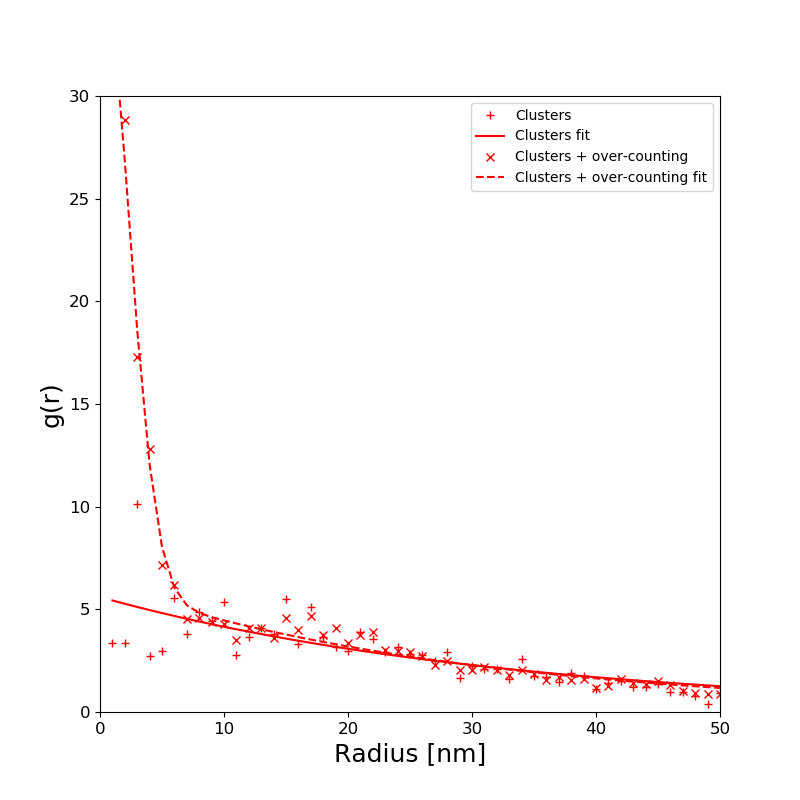

In [24]:
figure = plt.figure(figsize=(8,8), dpi=100)
ax = figure.add_subplot(111)
ax.plot(r[1:], r_centers[0, 1:], 'r+', label='Clusters')
ax.plot(r[1:], r_centers_curve[1:], 'r-', label='Clusters fit')
ax.plot(r[1:], r_all[0, 1:], 'rx', label='Clusters + over-counting')
ax.plot(r[1:], r_all_curve[1:], 'r--', label='Clusters + over-counting fit')
ax.set_xlim([0, 50])
ax.set_ylim([0, 30])
ax.tick_params(labelsize='large')
ax.legend()
plt.xlabel('Radius [nm]', fontsize=18)
plt.ylabel('g(r)', fontsize=18)
plt.show()

<IPython.core.display.Javascript object>


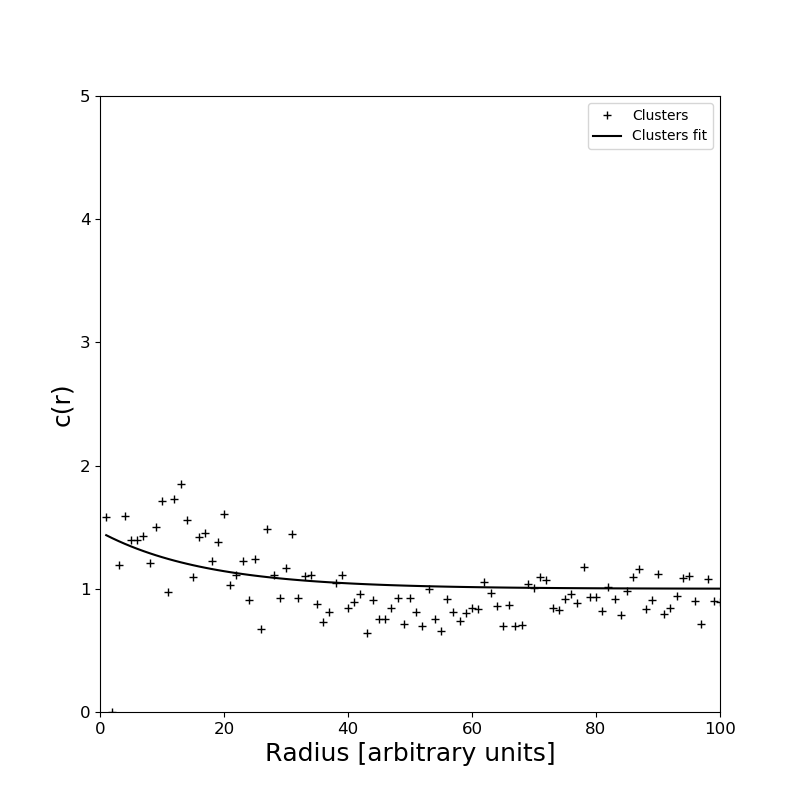

In [30]:
figure = plt.figure(figsize=(8,8), dpi=100)
ax = figure.add_subplot(111)
ax.plot(r[1:], cross_centers[0, 1:], 'k+', label='Clusters')
ax.plot(r[1:], cross_centers_curve[1:], 'k-', label='Clusters fit')
ax.set_xlim([0, 100])
ax.set_ylim([0, 5])
ax.tick_params(labelsize='large')
ax.legend()
plt.xlabel('Radius [arbitrary units]', fontsize=18)
plt.ylabel('c(r)', fontsize=18)
plt.show()

In [44]:
loc = np.array([5.0, 5.0])
print(loc.shape)
# add some over counting
num_ocr = 30
g = np.random.normal(loc, psf_sigma, size=(num_ocr, 2))
    
patches = [Circle((loc[0], loc[1]), psf_sigma, color='lightgrey')]

(2,)


<IPython.core.display.Javascript object>


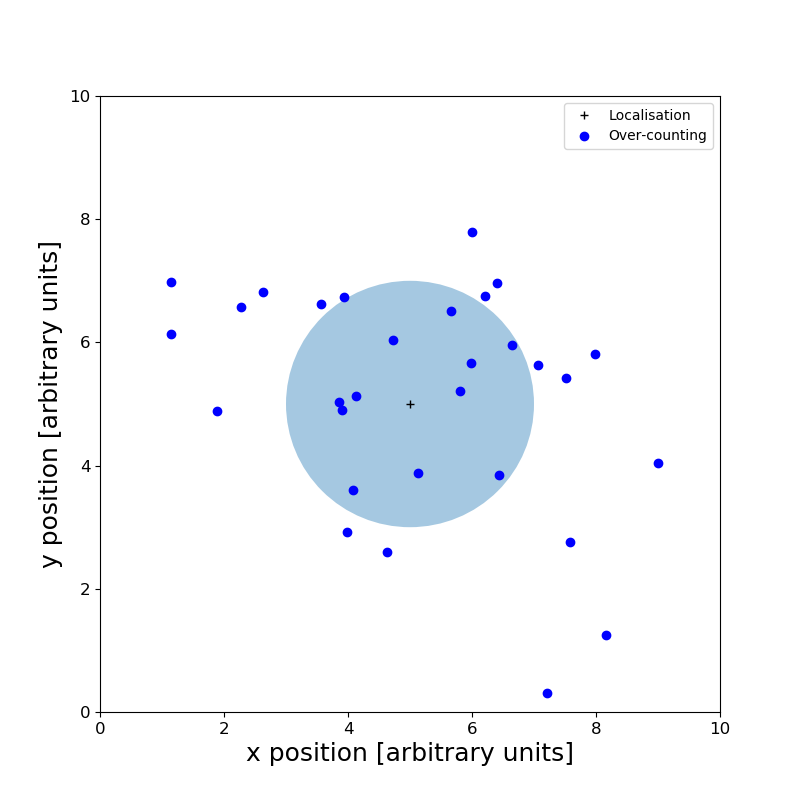

In [46]:
figure = plt.figure(figsize=(8,8), dpi=100)
ax = figure.add_subplot(111)
ax.plot(loc[0], loc[1], 'k+', label='Localisation')
ax.plot(g[:, 0], g[:, 1], 'bo', label='Over-counting')
p = PatchCollection(patches, alpha=0.4)
ax.add_collection(p)
ax.set_xlim([0, 10])
ax.set_ylim([0, 10])
ax.tick_params(labelsize='large')
ax.legend()
plt.xlabel('x position [arbitrary units]', fontsize=18)
plt.ylabel('y position [arbitrary units]', fontsize=18)
plt.show()

In [14]:
locs = pd.read_csv("test_data\\repeat_localisations.csv")
xy = locs.as_matrix(['x [nm]', 'y [nm]'])
xy

array([[2538.04224591, 2462.52074669],
       [2533.68698725, 2414.56459158],
       [2400.90396567, 2858.90486064],
       [2592.81181042, 2611.66541759],
       [2587.79277864, 2620.99765677],
       [2592.39422525, 2604.5799547 ],
       [2587.00827065, 2600.1957084 ],
       [2592.97348779, 2608.5545188 ],
       [2584.38045714, 2617.02121523],
       [2572.68663581, 2627.73930896],
       [2577.97215013, 2618.40511378],
       [2587.66242464, 2609.12766912],
       [2590.54479767, 2605.99042026],
       [2581.63286914, 2609.7247981 ],
       [2590.96378971, 2597.48962178],
       [2589.0564344 , 2594.18982366],
       [2603.96200395, 2612.94611246],
       [2613.38087309, 2604.66940595],
       [2600.11799258, 2612.00525188],
       [2599.0088924 , 2614.17748566],
       [2605.05539686, 2606.53712182],
       [2612.3613317 , 2622.78244647],
       [2592.6055792 , 2608.09909453],
       [2599.63678353, 2601.8338737 ],
       [2603.03376664, 2612.12859952],
       [2573.68852584, 26

<IPython.core.display.Javascript object>


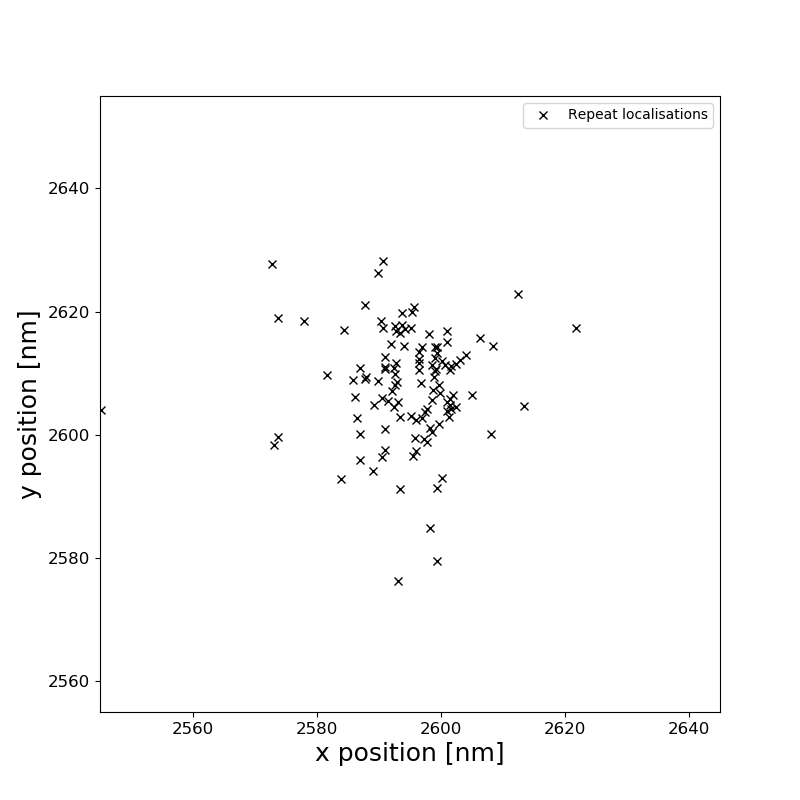

In [26]:
figure = plt.figure(figsize=(8,8), dpi=100)
ax = figure.add_subplot(111)
ax.plot(xy[:, 0], xy[:, 1], 'kx', label='Repeat localisations')
ax.set_xlim([2545, 2645])
ax.set_ylim([2555, 2655])
ax.tick_params(labelsize='large')
ax.legend()
plt.xlabel('x position [nm]', fontsize=18)
plt.ylabel('y position [nm]', fontsize=18)
plt.show()
plt.show()